# PyCPT_sv1.4 --13 September 2019
## Produce seasonal (un)calibrated forecasts and assess associated skill 

#### Authors: 
Nachiketa Acharya (nachiketa@iri.columbia.edu), Kyle Hall (kjh2171@columbia.edu)

#### Original Authors: 
Ángel G. Muñoz (agmunoz@iri.columbia.edu), Andrew W. Robertson (awr@iri.columbia.edu), Simon J. Mason (simon@iri.columbia.edu)

#### Acknowledgements: 
Rémi Cousin (IRI) for key Ingrid code development and support.
Xandre Chourio (IRI) for Windows and code support, and testing.
James Doss-Gollin (Columbia Water Center) developed the original download Python functions.
Part of the effort to develop PyCPT is funded by the Columbia World Project "Adapting Agriculture to Climate Today, for Tomorrow" (ACToday), and NOAA MAPP's projects NA18OAR4310275 (Muñoz) and NA16OAR4310145 (Robertson).


#### Input:
* Predictor is rainfall from S2S ECMWF (no realtime), or NCEP CFSv2 (realtime), or SubX GEFS (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7) or CPC Unified or IMD

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.


### Namelist section

In [1]:
########Work name (name of the work folder; e.g., one word followed by "_seasonal":)
#work='JJAS_May_CCA_CHIRPS'
work = 'Oy'
########Model (choose one, a subset or all models: 
#CMC1-CanCM3, CMC2-CanCM4,  COLA-RSMAS-CCSM4*, 
# GFDL-CM2p5-FLOR-A06*, GFDL-CM2p5-FLOR-B01*,GFDL-CM2p1-aer04*, NASA-GEOSS2S*, NCEP-CFSv2*)
#The ones with "*" are producing operation#al forecasts, the others are frozen. 
models=['COLA-RSMAS-CCSM4']#,'GFDL-CM2p5-FLOR-A06']#,'CMC1-CanCM3' 'GFDL-CM2p5-FLOR-B01','GFDL-CM2p1-aer04','CMC1-CanCM3', 'CMC2-CanCM4','NCEP-CFSv2']

########Obs (choose between CPC-CMAP-URD, CHIRPS, TRMM, CPC, Chilestations,GPCC)
obs='ENACTS-BD'
#obs='CHIRPS'
station=False

########MOS method (choose between None, PCR, CCA) #Esto es calibracion
MOS='CCA' 

#only used if MOS == 'CCA' or MOS == 'PCR'
xmodes_min = 1
xmodes_max = 8
ymodes_min = 2
ymodes_max = 10
ccamodes_min = 1
ccamodes_max = 5

########Predictand (choose between PRCP, RFREQ)
PREDICTAND='PRCP'

########Predictor (choose between GCM's PRCP, VQ, UQ)
#VQ and UQ only works with models=['NCEP-CFSv2']
PREDICTOR='PRCP'

########Target seasons and related parameters
##If more targets, increase the arrays accordingly
#mons=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
mons=['Jul']
tgti='1.5'  #S: start for the DL
tgtf='1.5'   #S: end for the DL
#for now, just write the target period (for DL)
#tgts=['Feb-Apr','Mar-May','Apr-Jun','May-Jul','Jun-Aug','Jul-Sep','Aug-Oct','Sep-Nov','Oct-Dec','Nov-Jan','Dec-Feb','Jan-Mar'] 
tgts=['Aug']

tini = 1982
tend = 2009

########Forecast date  
monf='Jul' 	# Initialization month 
fyr=2020 	# Forecast year

########Switches: 
force_download = False   #force download of data files, even if they already exist locally --- IF YOU ALREADY HAVE OBS FILES, DOUBLE CHECK WHICH ONES THEY ARE --- True to be safe

# ########Spatial domain for predictor
nla1=35 	# Northernmost latitude
sla1=15 	# Southernmost latitude
wlo1=80 	# Westernmost longitude
elo1=100 	# Easternmost longitude
# Spatial domain for predictand
nla2=28 	# Northernmost latitude
sla2=20 	# Southernmost latitude
wlo2=87 	# Westernmost longitude
elo2=94 	# Easternmost longitude




In [2]:
########Some folder and file options:
# Working directory --it should exist!!!
workdir = "/Users/kylehall/Projects/PyCPT-Dev/scripts/"
# PATH to CPT root directory
cptdir='/Users/kylehall/CPT/16.5.8/'
    
print("PyCPT folder is:")
%cd $workdir
!mkdir $work 

PyCPT folder is:
/Users/kylehall/Projects/PyCPT-Dev/scripts
mkdir: Oy: File exists


### End of namelist section  (do not modify anything below this line)

#### Load Libraries

In [3]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import subprocess
from pycpt_functions_seasonal import *
from scipy.stats import t
if MOS=='ELR':
    from sklearn.linear_model import LogisticRegression
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
import platform

########Set Up Useful Variables Automatically 
rainfall_frequency, threshold_pctle, wetday_threshold, obs_source, hdate_last,\
 mpref, L, ntrain, fprefix, nmonths, ndays = setup_params(PREDICTOR,obs,MOS,tini,tend, tgts)

print("Python libraries loaded")
print("Now in the work folder:")
%cd $work
workdir = os.getcwd()

if platform.system() == 'Windows':
    !del /S /Q scripts
    !rmdir /S /Q scripts
else:    
    !rm -Rf scripts/*

/Users/kylehall/anaconda/envs/pycpt_env37/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


Predictand is Rainfall Total (mm)
Python libraries loaded
Now in the work folder:
/Users/kylehall/Projects/PyCPT-Dev/scripts/Oy


In [4]:
print("Creating working folders, if not already there...")
print("Work directory is:")
%cd $workdir
!mkdir input
!mkdir output
!mkdir scripts
!mkdir images



# Set up CPT environment
os.environ["CPT_BIN_DIR"] = cptdir
print("CPT environment loaded...")
#print("CPT version is "+str(wetday_threshold))

Creating working folders, if not already there...
Work directory is:
/Users/kylehall/Projects/PyCPT-Dev/scripts/Oy
mkdir: input: File exists
mkdir: output: File exists
mkdir: scripts: File exists
mkdir: images: File exists
CPT environment loaded...


## Check if domains are ok --if you don't like them, go back to the namelist and modify them

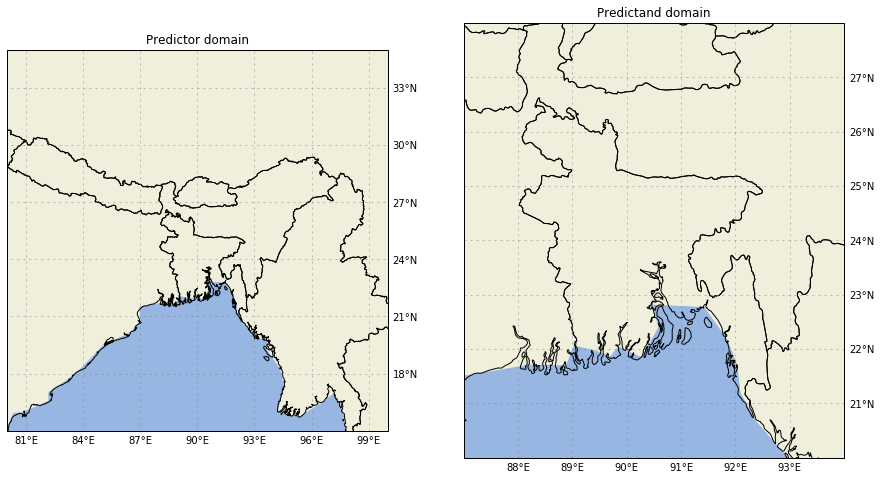

In [5]:
#Plot domains
pltdomain(wlo1,elo1,nla1,sla1,wlo2,elo2,nla2,sla2)

# Download data if necessary, and run CPT

In [6]:
#mons=['Jan','Dec']
mons=['Jul']
tgti='1.5'  #S: start for the DL
tgtf='1.5'   #S: end for the DL
#for now, just write the target period (for DL)
#tgts=['Feb-Apr','Jan-Mar'] 
tgts=['Aug']

#If downloadling data from several models, this section might take a while to be done
for model in models:
    print('')
    print('')
    print('----Starting process for '+model+'----')
    #for mon in mons:
        #tar=tgts[mons.index(mon)]
    for i in range(len(mons)):
        tar, mon = tgts[i], mons[i]
        ########Set Up Useful Variables Automatically 
        rainfall_frequency, threshold_pctle, wetday_threshold, obs_source, hdate_last,\
        mpref, L, ntrain, fprefix, nmonths, ndays = setup_params(PREDICTOR,obs,MOS,tini,tend, tgts[i])

    
        print("New folder:")
        if platform.system() == 'Windows':
            %cd $workdir\input
        else:
            %cd $workdir/input
            
        print('Preparing CPT files for '+model+' and initialization '+mon+'...')
        PrepFiles(fprefix, PREDICTAND, threshold_pctle, wlo1, wlo2,elo1, elo2, sla1, sla2, nla1, nla2, tgti, tgtf, mon, monf, fyr, os, wetday_threshold, tar, model, obs_source, hdate_last, force_download,station,ndays, nmonths, tini, tend)
 
        print("New folder:")
        if platform.system() == 'Windows':
            %cd $workdir\scripts
        else:
            %cd $workdir/scripts

        CPTscript(model,PREDICTAND, mon,monf, fyr, nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,tar,ntrain,MOS,station, xmodes_min, xmodes_max, ymodes_min, ymodes_max, ccamodes_min, ccamodes_max, tini, tend)

        print('Executing CPT for '+model+' and initialization '+mon+'...')
        try:
            if platform.system() == "Windows":
                print('on windows')
                print(''.join([ cptdir+'CPT_batch.exe', '<', 'params', '>', 'CPT_stout_train_'+model+'_'+tar+'_'+mon+'.txt']))
                subprocess.check_output([ cptdir+'CPT.x', '<', 'params', '>', 'CPT_stout_train_'+model+'_'+tar+'_'+mon+'.txt'] , shell=True)
            else:
                subprocess.check_output(cptdir+'CPT.x < params > CPT_stout_train_'+model+'_'+tar+'_'+mon+'.txt',stderr=subprocess.STDOUT, shell=True)
        except subprocess.CalledProcessError as e:
            print(e.output.decode())
            raise
            #print('broken')
        print('----------------------------------------------')
        print('Calculations for '+mon+' initialization completed!')
        print('See output folder, and check scripts/CPT_stout_train_'+model+'_'+tar+'_'+mon+'.txt for errors')
        print('----------------------------------------------')
        print('----------------------------------------------')

print('')
print('')
print('')
print('\033[1mPROCESS COMPLETED \033[0;0m')



----Starting process for COLA-RSMAS-CCSM4----
New folder:
/Users/kylehall/Projects/PyCPT-Dev/scripts/Oy/input
Preparing CPT files for COLA-RSMAS-CCSM4 and initialization Jul...
Hindcasts file doesn't exist --SOLVING: downloading file

 Hindcasts URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/S/%280000%201%20Jul%201982-2009%29/VALUES/L/1.5/1.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/30/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  180k    0  180k    0     0  18302      0 --:--:--  0:00:10 --:--:-- 23168
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
------------------------------------

## Deterministic Skill Analysis

Present folder:
/Users/kylehall/Projects/PyCPT-Dev/scripts/Oy/output

Pearson



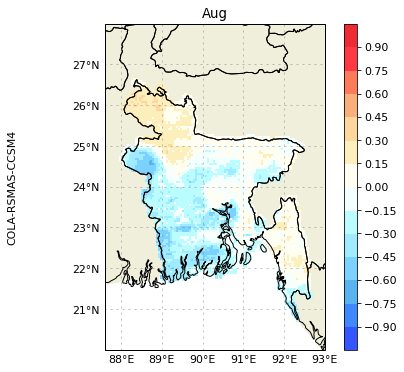


Spearman



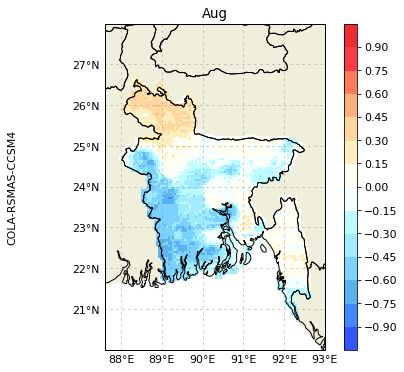


2AFC



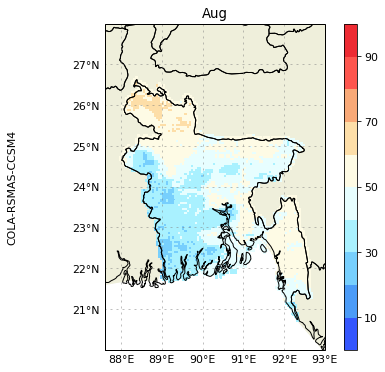


RocAbove



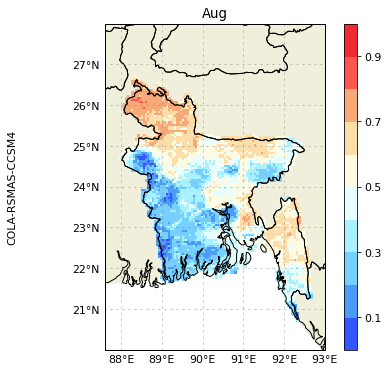


RocBelow



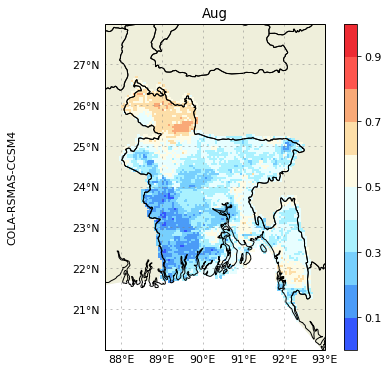


RMSE



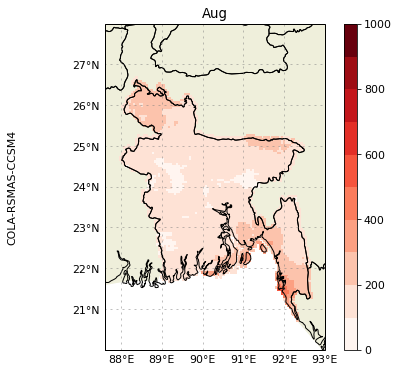

In [7]:
#####Choose metrics (options are: 'Pearson','Spearman','2AFC','RocAbove','RocBelow', 'RMSE'):
met=('Pearson','Spearman','2AFC','RocAbove','RocBelow', 'RMSE')
#monss=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']   #Needs to be any of the seasons computed.
monss=['Aug'] 

print("Present folder:")
if platform.system() == 'Windows':
    %cd $workdir\output
else:
    %cd $workdir/output

# Skill scores loop
plt.rcParams.update({'font.size': 11})
for ime in met:
    pltmap(models,PREDICTAND,ime,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts,mons,monss, obs)   
    print('')
    print("\033[1m"+ime+"\033[0;0m")
    #plt.show()
    print('')
    plt.savefig("1_"+ime+".png",dpi=500)
    #plt.close()
    plt.show()

##### EOF Analysis (only available if MOS=PCR or CCA)

Present folder:
/Users/kylehall/Projects/PyCPT-Dev/scripts/Oy/output


Mode 1


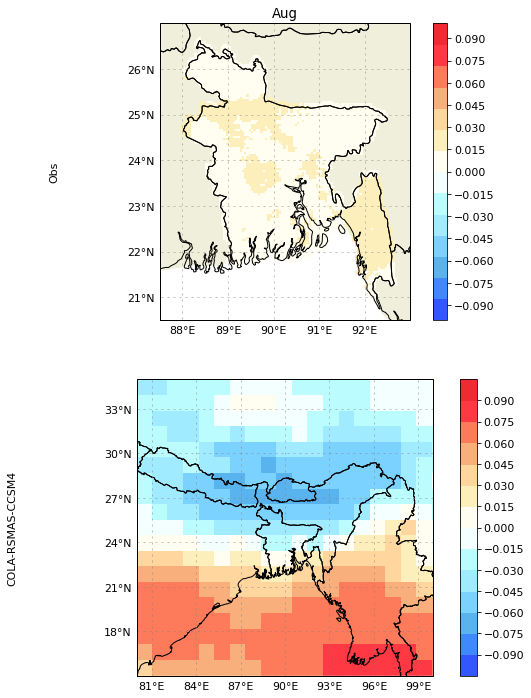

Mode 2


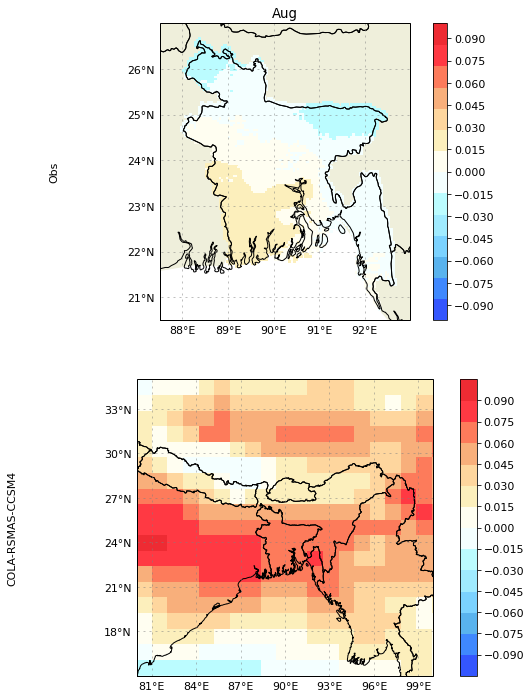

Mode 3


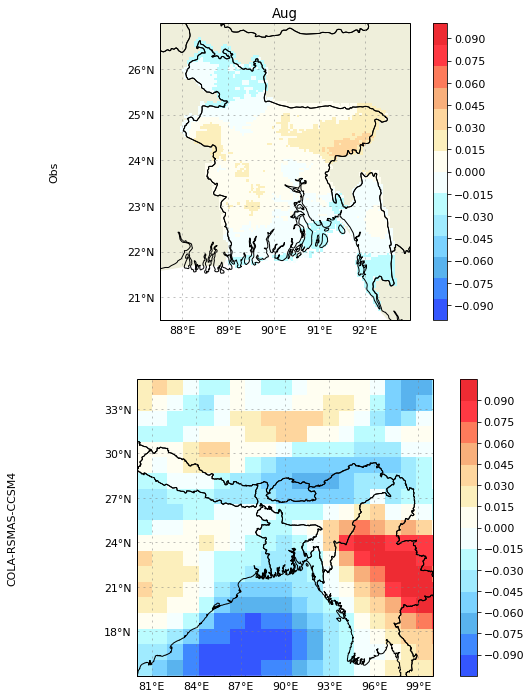

In [8]:
#monss=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']   #Needs to be any of the seasons computed.
monss=['Aug'] 

print("Present folder:")
if platform.system() == 'Windows':
    %cd $workdir\output
else:
    %cd $workdir/output
print('')
print('')

# Skill scores loop
nmodes=3
if MOS != "None":
    for imod in range(nmodes):
        plteofs(models,PREDICTAND,imod,nmodes,wlo1,elo1,sla1,nla1,fprefix,mpref,tgts, mons,monss,fyr, obs)  #try to plot predictor domain 
        print("Mode "+str(imod+1))
        #plt.show()
        plt.savefig("2_eof"+str(imod+1)+".png",dpi=500)
        #plt.close()
        plt.show()

## Multi-model ensemble: NextGen

In [9]:
#List of selected models:
#models=['CMC2-CanCM4', 'GFDL-CM2p5-FLOR-A06','NCEP-CFSv2']
#models=['CMC1-CanCM3', 'CMC2-CanCM4', 'COLA-RSMAS-CCSM4', 'GFDL-CM2p5-FLOR-A06', 'GFDL-CM2p5-FLOR-B01', 'NASA-GEOSS2S', 'NCEP-CFSv2']
#models=['GFDL-CM2p5-FLOR-A06']

models=[ 'COLA-RSMAS-CCSM4']#,'GFDL-CM2p5-FLOR-A06'] #, 'GFDL-CM2p5-FLOR-B01','GFDL-CM2p1-aer04','CMC1-CanCM3', 'CMC2-CanCM4','NCEP-CFSv2']


In [10]:
print('----Assessing skill for NextGen----')
model='NextGen'
MOS='None'   #we're changing here to no MOS to assess skill of NextGen
file='FCST_xvPr'

for mon in mons:
    tar=tgts[mons.index(mon)]
    print("New folder:")
    if platform.system() == 'Windows':
        %cd $workdir\input
    else:
        %cd $workdir/input

    print('Preparing CPT files for '+model+' and initialization '+mon+'...')
    NGensemble(models,fprefix,PREDICTAND,mpref,file,tar,mon,tgti,tgtf,monf,fyr)
    
    print("New folder:")
    if platform.system() == 'Windows':
        %cd $workdir\scripts
    else:
        %cd $workdir/scripts

    CPTscript(model,PREDICTAND, mon,monf, fyr, nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,tar,ntrain,MOS,station, xmodes_min, xmodes_max, ymodes_min, ymodes_max, ccamodes_min, ccamodes_max, tini, tend)

    print('Executing CPT for '+model+' and initialization '+mon+'...')
    try:
        subprocess.check_output(cptdir+'CPT.x < params > CPT_stout_train_'+model+'_'+tar+'_'+mon+'.txt',stderr=subprocess.STDOUT, shell=True)
    except subprocess.CalledProcessError as e:
        print(e.output.decode())
        raise
    print('----------------------------------------------')
    print('Calculations for '+mon+' initialization completed!')
    print('See output folder, and check scripts/CPT_stout_train_'+model+'_'+tar+'_'+mon+'.txt for errors')
    print('----------------------------------------------')
    print('----------------------------------------------')

print('')
print('')
print('')
print('\033[1mPROCESS COMPLETED \033[0;0m')

----Assessing skill for NextGen----
New folder:
/Users/kylehall/Projects/PyCPT-Dev/scripts/Oy/input
Preparing CPT files for NextGen and initialization Jul...
Cross-validated prediction files successfully produced
New folder:
/Users/kylehall/Projects/PyCPT-Dev/scripts/Oy/scripts
Executing CPT for NextGen and initialization Jul...
----------------------------------------------
Calculations for Jul initialization completed!
See output folder, and check scripts/CPT_stout_train_NextGen_Aug_Jul.txt for errors
----------------------------------------------
----------------------------------------------



PROCESS COMPLETED 


New folder:
/Users/kylehall/Projects/PyCPT-Dev/scripts/Oy/output

Pearson



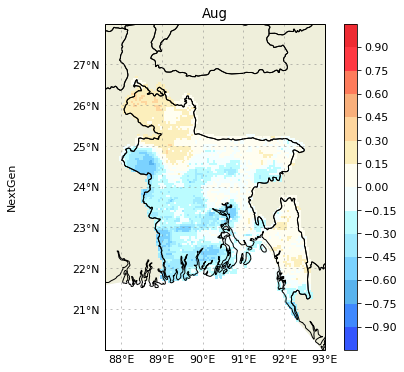


Spearman



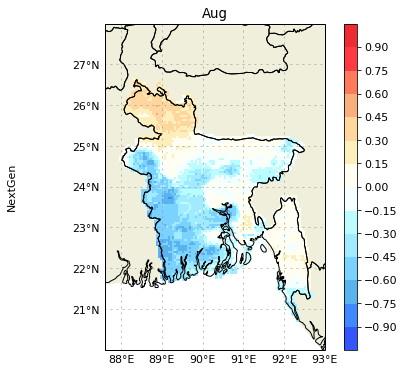


2AFC



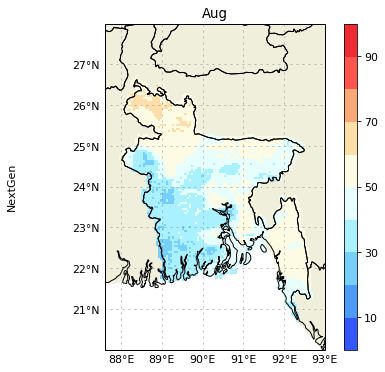


RocAbove



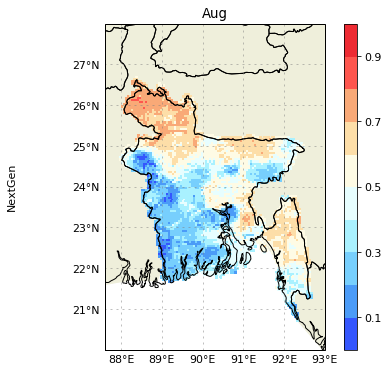


RocBelow



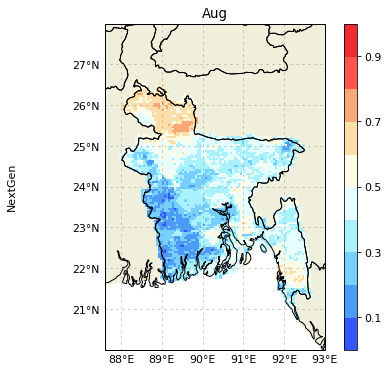


RMSE



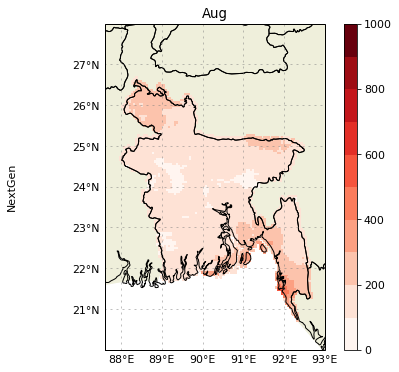

In [11]:
#####Choose metrics (options are: 'Pearson','Spearman','2AFC','RocAbove','RocBelow'):
met=('Pearson','Spearman','2AFC','RocAbove','RocBelow', 'RMSE')
#monss=['Dec-Feb','Mar-May','Apr-Jun','Sep-Nov']   #Needs to be any of the seasons computed.
monss=['Aug'] 
modelo=['NextGen']

print("New folder:")
if platform.system() == 'Windows':
    %cd $workdir\output
else:
    %cd $workdir/output

# Skill scores loop
plt.rcParams.update({'font.size': 11})
for ime in met:
    pltmap(modelo,PREDICTAND,ime,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts,mons,monss, obs)   
    print('')
    print("\033[1m"+ime+"\033[0;0m")
    #plt.show()
    print('')
    plt.savefig("3_nextGen"+ime+".png",dpi=300)
    plt.show()

# Real-Time Forecast

New folder:
/Users/kylehall/Projects/PyCPT-Dev/scripts/Oy/output


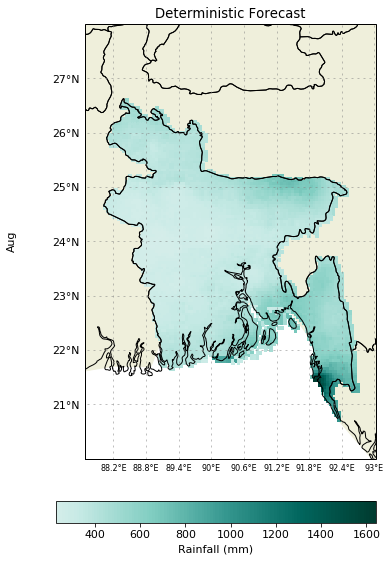

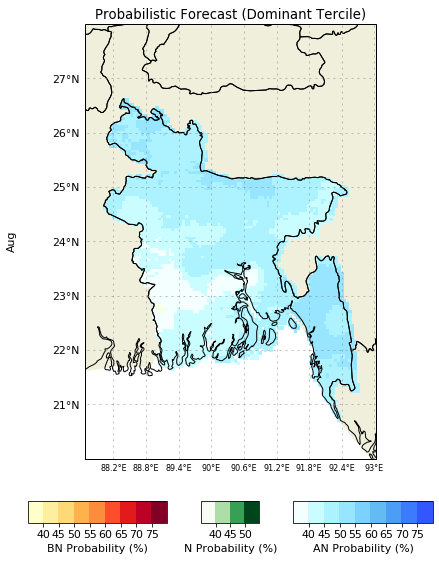

In [12]:
print("New folder:")
if platform.system() == 'Windows':
    %cd $workdir\output
else:
    %cd $workdir/output

plt_ng_deterministic(models, PREDICTAND, wlo2,elo2,sla2,nla2, fprefix, mpref, monss, mon, fyr)
plt_ng_probabilistic(models, PREDICTAND, wlo2,elo2,sla2,nla2, fprefix, mpref, monss, mon, fyr)

In [13]:
print("Present folder:")
if platform.system() == 'Windows':
    %cd $workdir/output
else:
    %cd $workdir/output
ensemblefiles(modelo,work)

Present folder:
/Users/kylehall/Projects/PyCPT-Dev/scripts/Oy/output
cp: ../*NextGen*.txt: No such file or directory
a COLA-RSMAS-CCSM4_PRCP_CCAFCST_Obs_Aug_Jul2020.txt
a COLA-RSMAS-CCSM4_PRCP_CCAFCST_P_Aug_Jul2020.txt
a COLA-RSMAS-CCSM4_PRCP_CCAFCST_mu_Aug_Jul2020.txt
a COLA-RSMAS-CCSM4_PRCP_CCAFCST_var_Aug_Jul2020.txt
a COLA-RSMAS-CCSM4_PRCP_CCAFCST_xvPr_Aug_Jul2020.txt
a COLA-RSMAS-CCSM4_PRCP_CCAFCST_z_Aug_Jul2020.txt
a COLA-RSMAS-CCSM4_PRCP_CCA_2AFC_Aug_Jul2020.txt
a COLA-RSMAS-CCSM4_PRCP_noMOSFCST_Obs_Aug_Jul2020.txt
a COLA-RSMAS-CCSM4_PRCP_noMOSFCST_P_Aug_Jul2020.txt
a COLA-RSMAS-CCSM4_PRCP_noMOSFCST_mu_Aug_Jul2020.txt
a COLA-RSMAS-CCSM4_PRCP_noMOSFCST_var_Aug_Jul2020.txt
a COLA-RSMAS-CCSM4_PRCP_noMOSFCST_xvPr_Aug_Jul2020.txt
a COLA-RSMAS-CCSM4_PRCP_noMOSFCST_z_Aug_Jul2020.txt
a COLA-RSMAS-CCSM4_PRCP_noMOS_2AFC_Aug_Jul2020.txt
a COLA-RSMAS-CCSM4_RFCST_PRCP_Aug_iniJul2020.txt
a COLA-RSMAS-CCSM4_RFCST_reliabdiag_PRCP_Aug_iniJul2020.tsv.txt
a NextGen_PRCP_CCAFCST_Obs_Aug_Jul2020.txt

### Flexible Forecasts

Folder:
/Users/kylehall/Projects/PyCPT-Dev/scripts/Oy/output


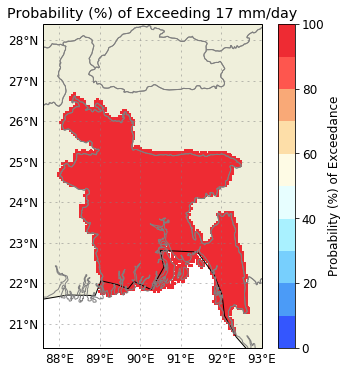

In [14]:
flexformat_threshold = 17 #threshold for the flexible format map

#CPC: Al parecer lluvia total trimestral
#CHIRPS: mm/dia

print("Folder:")
if platform.system() == 'Windows':
    %cd $workdir\output
else:
    %cd $workdir/output
plt.rcParams.update({'font.size': 12})
pltmapff(models,PREDICTAND,flexformat_threshold,ntrain,wlo2,elo2,sla2,nla2,fprefix,mpref,monf,fyr,mons,tgts, obs)
#plt.savefig("ProbFcst_Flex.pdf", dpi=300)

Folder:
/Users/kylehall/Projects/PyCPT-Dev/scripts/Oy/output


ValueError: Axis limits cannot be NaN or Inf

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


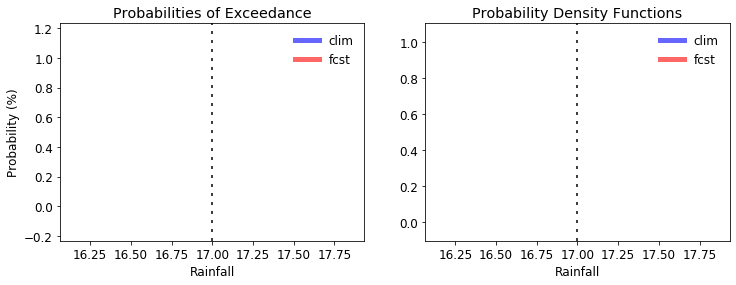

In [15]:
#flexformat_threshold = 10. #threshold for the flexible format map (in mm/week)
lon=78
lat=18
 
print("Folder:")
if platform.system() == 'Windows':
    %cd $workdir\output
else:
    %cd $workdir/output
plt.rcParams.update({'font.size': 12})
pltprobff(models,PREDICTAND,flexformat_threshold,ntrain,lon,lat,wlo2,elo2,sla2,nla2,fprefix,mpref,monf,fyr,mons,tgts)
plt.savefig("ProbExceed.pdf", dpi=300)

In [ ]:
models,fprefix,predictand,mpref,id,tar,mon,tgti,tgtf,monf,fyr